## 1. Import Library

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [116]:
# setting hyperparameter
batch_size = 32
epochs = 200
lr = 0.01
train_ratio = 0.9

## 2. 匯入MINIST手寫辨識數據集以及資料前處理
使用sklearn 8x8 的手寫數字數據集

In [117]:
from sklearn.datasets import load_digits

digits = load_digits()
x_, y_ = digits.data, digits.target
# min-max normalization
x_ = x_ / x_.max() 

# one hot encoding
y_one_hot = np.eye(10)[y_]


## 3. Split your data into training and validation sets

In [118]:
x_train, x_test, y_train, y_test = train_test_split(x_, 
                                                    y_one_hot, 
                                                    test_size=0.05, 
                                                    stratify=y_)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, 
                                                      y_train, 
                                                      test_size=1.0 - train_ratio,
                                                      stratify=y_train.argmax(axis=1))

print("training set data dimension")
print(x_train.shape)
print(y_train.shape)
print("-----------")
print("training set: {}".format(len(x_train)))
print("validation set: {}".format(len(x_valid)))
print("testing set: {}".format(len(x_test)))

training set data dimension
(1536, 64)
(1536, 10)
-----------
training set: 1536
validation set: 171
testing set: 90


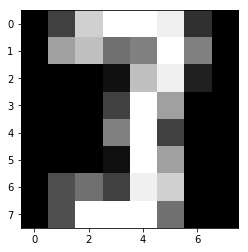

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [119]:
plt.imshow(x_train[0].reshape(8, 8), cmap='gray')
plt.show()
print(y_train[0])

## 4.Build the network with low-level tensor elements

In [120]:
# build the graph
tf.reset_default_graph()

with tf.name_scope('input'):
    x_input = tf.placeholder(shape=(None, 64), name='x_input', dtype=tf.float32)
    y_out = tf.placeholder(shape=(None, 10), name='y_label', dtype=tf.float32)

with tf.variable_scope('hidden_layer'):
    w1 = tf.Variable(tf.truncated_normal(shape=[64, 25], stddev=0.1),
                     name='weight1',
                     dtype=tf.float32)
    b1 = tf.Variable(tf.constant(0.0, shape=[25]),
                     name='bias1', 
                     dtype=tf.float32)
    z1 = tf.add(tf.matmul(x_input, w1), b1)  # (None, 64)×(64, 25)+(None, 25) = (None, 25)
    a1 = tf.nn.relu(z1, name='h1_out')
    
with tf.variable_scope('output_layer'):
    w2 = tf.Variable(tf.truncated_normal(shape=[25, 10], stddev=0.1), # 這個函數產生的隨機數與均值的差距不會超過兩倍的標準差
                     name='weight2',
                     dtype=tf.float32)
    b2 = tf.Variable(tf.constant(0.0, shape=[10]),
                     name='bias2', 
                     dtype=tf.float32)
    output = tf.add(tf.matmul(a1, w2), b2, name='output')

with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y_out), name='loss')
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output), 1), tf.argmax(y_out, 1)) 
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

In [121]:
tf.global_variables()

[<tf.Variable 'hidden_layer/weight1:0' shape=(64, 25) dtype=float32_ref>,
 <tf.Variable 'hidden_layer/bias1:0' shape=(25,) dtype=float32_ref>,
 <tf.Variable 'output_layer/weight2:0' shape=(25, 10) dtype=float32_ref>,
 <tf.Variable 'output_layer/bias2:0' shape=(10,) dtype=float32_ref>]

## 5.Train the model and record the performance

In [122]:
# create a session and train the model
train_loss_epoch, valid_loss_epoch = [], []
train_acc_epoch, valid_acc_epoch = [], []

sess = tf.Session()
    
sess.run(tf.global_variables_initializer())

for i in tqdm_notebook(range(epochs)):

    total_batch = len(x_train) // batch_size 
    train_loss_batch, train_acc_batch = [], []

#     training
    for j in range(total_batch):

        batch_idx_start = j * batch_size
        batch_idx_stop = (j+1) * batch_size

        x_batch = x_train[batch_idx_start : batch_idx_stop]  # xbatch = xtrain[0:32], xbatch = xtrain[32:64], and so on...
        y_batch = y_train[batch_idx_start : batch_idx_stop]

        batch_loss, batch_acc, _ = sess.run([loss, compute_acc, train_step], 
                                            feed_dict={x_input: x_batch, y_out: y_batch})

        train_loss_batch.append(batch_loss) 
        train_acc_batch.append(batch_acc)  

#     validation
    valid_acc, valid_loss = sess.run([compute_acc, loss],
                                     feed_dict={x_input: x_valid, y_out : y_valid})
    
#     collect loss and accuracy
    train_loss_epoch.append(np.mean(train_loss_batch)) 
    train_acc_epoch.append(np.mean(train_acc_batch))
    valid_loss_epoch.append(valid_loss) 
    valid_acc_epoch.append(valid_acc) 

    x_train, y_train = shuffle(x_train, y_train)
    
print('--- training done ---')


--- training done ---


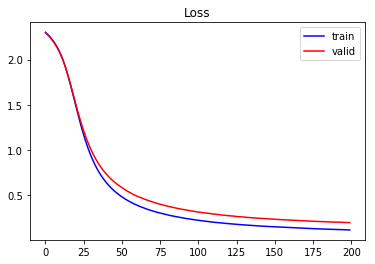

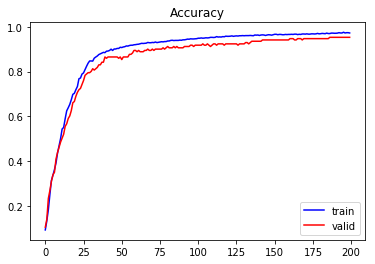

In [123]:
# plot
plt.plot(train_loss_epoch, 'b', label='train')
plt.plot(valid_loss_epoch, 'r', label='valid')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(train_acc_epoch, 'b', label='train')
plt.plot(valid_acc_epoch, 'r', label='valid')
plt.legend(loc=4)
plt.title("Accuracy")
plt.show()

In [124]:
pred, test_acc, test_loss = sess.run([output,compute_acc, loss],
                                feed_dict = {x_input: x_test, y_out : y_test})

print('testing accuracy: {:.2f}'.format(test_acc))

# sess.close()

testing accuracy: 0.98


In [125]:
pred=np.argmax(pred, axis=1)
y_test_label=np.argmax(y_test, axis=1)

In [126]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(x_test)):
    if(y_test_label[i]==pred[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(x_test)):
    if(y_test_label[i]!=pred[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

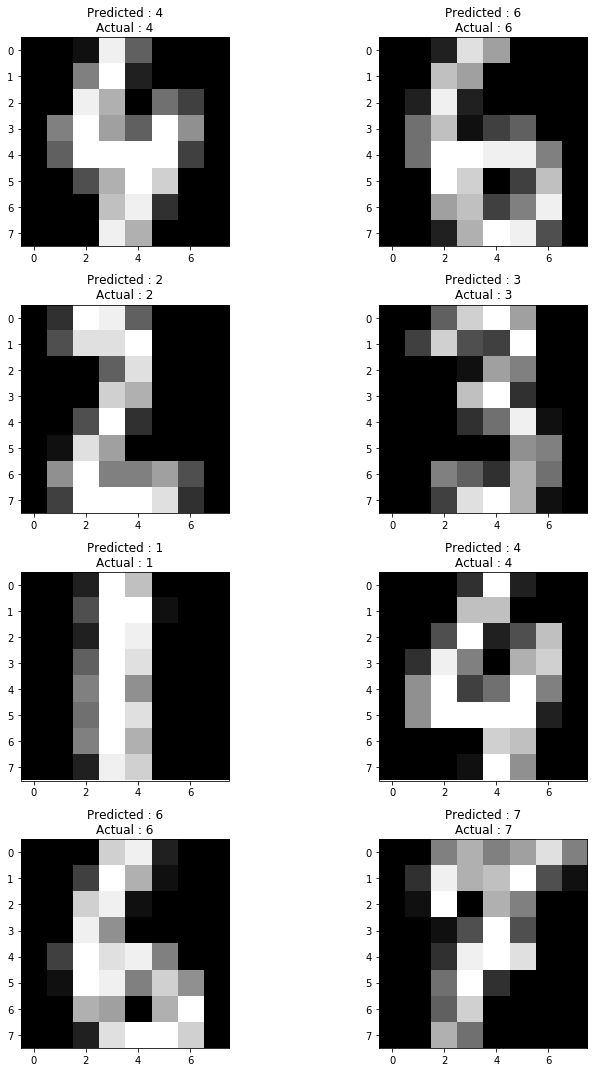

In [127]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]].reshape(8, 8), cmap='gray')
        ax[i,j].set_title("Predicted : "+str(pred[prop_class[count]])+"\n"+"Actual : "+str(y_test_label[prop_class[count]]))
        plt.tight_layout()
        count+=1

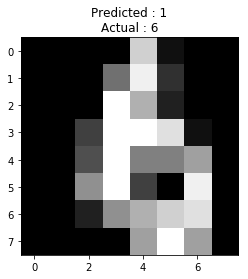

In [134]:

plt.imshow(x_test[mis_class[0]].reshape(8, 8), cmap='gray')
plt.title("Predicted : "+str(pred[mis_class[0]])+"\n"+"Actual : "+str(y_test_label[mis_class[0]]))
plt.show()